In [1]:
import tensorflow as tf

In [2]:
def define_model(width, height):
    
    base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', 
                                                                             include_top=False, 
                                                                             input_shape=(width, height, 3))
    
    input_layer = tf.keras.Input(shape=(width, height, 3))
    base = base_model(input_layer)
    vectors = tf.keras.layers.GlobalAveragePooling2D()(base)
    
    first_dense_layer = tf.keras.layers.Dense(64, activation='relu')(vectors)
    dropout_layer = tf.keras.layers.Dropout(0.5)(first_dense_layer)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(dropout_layer)
    
    model = tf.keras.Model(input_layer, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    metric = tf.keras.metrics.AUC()
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metric)
    
    return model

In [3]:
def define_generators():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
        rescale=1./255,
        validation_split=0.2)

    train_generator = train_datagen.flow_from_directory(
        directory='./train/',
        target_size=(width, height),
        batch_size=16,
        class_mode="categorical",
        color_mode="rgb",
        subset="training")
    
    validation_generator = train_datagen.flow_from_directory(
        directory='./train',
        target_size=(width, height),
        batch_size=16,
        class_mode="categorical",
        color_mode="rgb",
        subset="validation")
    
    return train_generator, validation_generator

In [4]:
def define_callbacks():
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="inception_resnet_v2_model.h5",
        monitor='val_auc',
        save_best_only=True,
        verbose=1,
        mode='max')

    return save_callback

In [5]:
nb_epoch     = 8
batch_size   = 16
width        = 299
height       = 299

In [6]:
model = define_model(width, height)

In [7]:
train_generator, validation_generator = define_generators()

Found 4100 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [8]:
history = model.fit(
                train_generator,
                epochs=nb_epoch,
                validation_data= validation_generator,
                verbose=1,
                callbacks=define_callbacks())

Epoch 1/8
257/257 [==============================] - ETA: 0s - loss: 1.1142 - auc: 0.7692
Epoch 1: val_auc improved from -inf to 0.66797, saving model to inception_resnet_v2_model.h5
257/257 [==============================] - 176s 601ms/step - loss: 1.1142 - auc: 0.7692 - val_loss: 42.3449 - val_auc: 0.6680
Epoch 2/8
257/257 [==============================] - ETA: 0s - loss: 0.9728 - auc: 0.8145
Epoch 2: val_auc improved from 0.66797 to 0.73021, saving model to inception_resnet_v2_model.h5
257/257 [==============================] - 150s 584ms/step - loss: 0.9728 - auc: 0.8145 - val_loss: 1.0772 - val_auc: 0.7302
Epoch 3/8
257/257 [==============================] - ETA: 0s - loss: 0.9422 - auc: 0.8244
Epoch 3: val_auc improved from 0.73021 to 0.73421, saving model to inception_resnet_v2_model.h5
257/257 [==============================] - 151s 588ms/step - loss: 0.9422 - auc: 0.8244 - val_loss: 1.0827 - val_auc: 0.7342
Epoch 4/8
257/257 [==============================] - ETA: 0s - loss: 

In [9]:
final_model = tf.keras.models.load_model('inception_resnet_v2_model.h5')

In [10]:
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260   

In [11]:
test_images = tf.keras.utils.image_dataset_from_directory('test/', 
                                                          label_mode='categorical', 
                                                          image_size=(299, 299),
                                                          shuffle=False)

Found 1279 files belonging to 4 classes.


In [12]:
print(final_model.evaluate(test_images))

40/40 [==============================] - 20s 374ms/step - loss: 1.0793 - auc: 0.7305
[1.0793309211730957, 0.730518639087677]


In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

In [14]:
tflite_converted_model = converter.convert()
with open('alzeimer_disease_prediction.tflite', 'wb') as f_out:
    f_out.write(tflite_converted_model)

INFO:tensorflow:Assets written to: /tmp/tmplkecxb6s/assets


INFO:tensorflow:Assets written to: /tmp/tmplkecxb6s/assets
2022-12-03 08:15:34.049934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-03 08:15:34.049971: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


In [15]:
from tensorflow.keras.preprocessing.image import load_img

sample_test_image = load_img('test_images/testing_images/26 (100).jpg', target_size=(299, 299))

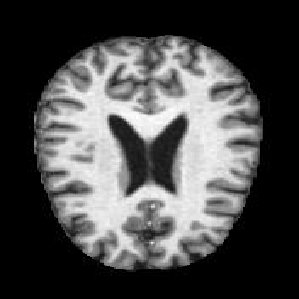

In [16]:
sample_test_image

In [18]:
import numpy as np

x = np.array(sample_test_image)
X = np.array([x])
X = tf.keras.applications.inception_resnet_v2.preprocess_input(X)

prediction = final_model.predict(X)
print(prediction)

1/1 [==============================] - 0s 45ms/step
[[0.21316227 0.01679706 0.35784283 0.4121978 ]]


In [22]:
train_generator.class_indices.keys()

dict_keys(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])